## Synthetic controls, Publicly traded Unicorns, and Foreing exchange restrictions

Imagine you are a quantitative analyst at a hedge fund. Last week, news broke out that Argentina is lifting the "cepo cambiario', which is foreign exchange restricition that restricts how much US dollars argentinians can buy. After the annoucement, part of the press said that Argentinian stocks soared. One of the companies of your portfolio is Mercado Libre, an argentinian e-commerce giant and you own 1000 shares. Your boss tells you that the stock in fact went up, but so did other e-commerce stocks as well that have nothing to do with Argentina and its messy economy. He wants you to quantify the __effect__ of this new argentinian monetary policy change in the protfolio. What do you do? 

I have set up this small exercise to:

    1) Explore how synthetic controls could help us answer this question

    2) Refresh some finance concepts
    
    3) Find out if Mercado Libre benefitted from the cepo lift.

__Synthetic controls:__ the synthetic control method is a method used to evaluate the effect of large-scale interventions. It is a weighted average of several units (such as regions or companies) combined to recreate the trajectory that the outcome of a treated unit would have followed in the absence of the intervention.

In other words, we will run a simple regression to predict the mercado libre stock in a world where "cepo cambiario" is still in place. Then, we will measure the differences with the current "world".

Now it gets tricky, to do that, we need the weighted average sum of similar companies to mercado libre. but what is similar? We cannot use other argentinian companies because if we regress over them, our result will be biased since they are also affected by the cepo cambiario. So are choices are:

-Other e-commerce companies? Could work. But how similar is mercado libre to amazon?

 -Other tech companies? Could work. But how similar is mercado libre to microsoft?

 -Other emerging market e-commerces? A good option, we will look at possibilities

 -Other companies with similar beta? Could work, beta is a measure of the volatility or systematic risk of a security. MELI is a high beta stock

 -All of the above? Yes, since we are using a weighted average a linear regression will take care of the coefficients for us. So we dont have to worry to which company to assign a bigger component.


So, first step: get the data:
We are going to get data from the last 2 years from Amazon and Ebay (e-commerce), Nubank (tech company from brasil), Sea Ltd (similar beta) ,MSTC Ltd (e-commerce from emerging market) 

In [ ]:
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import statsmodels.api as sm    
import statsmodels.formula.api as smf
from sklearn.linear_model import Lasso
from sklearn.model_selection import train_test_split


In [535]:
start_fecha='2025-01-01'
end_fecha= '2025-04-29'
MELI=yf.download('MELI', start=start_fecha, end= end_fecha)['Close']
DASH=yf.download('DASH', start=start_fecha, end= end_fecha)['Close']
NU=yf.download('NU', start=start_fecha, end= end_fecha)['Close']
EBAY=yf.download('EBAY', start=start_fecha, end= end_fecha)['Close']
SHOP=yf.download('SHOP', start=start_fecha, end= end_fecha)['Close']
SE=yf.download('SE', start=start_fecha, end= end_fecha)['Close']
PINS=yf.download('PINS', start=start_fecha, end= end_fecha)['Close']
ETSY=yf.download('ETSY', start=start_fecha, end= end_fecha)['Close']
PAGS =yf.download('PAGS ', start=start_fecha, end= end_fecha)['Close']
STNE =yf.download('STNE ', start=start_fecha, end= end_fecha)['Close']
AMZN=yf.download('AMZN', start=start_fecha, end= end_fecha)['Close']
PDD=yf.download('PDD', start=start_fecha, end= end_fecha)['Close']

data = MELI.join([DASH, NU, EBAY,SHOP,SE,PINS,ETSY,AMZN,PAGS,STNE,PDD])

data.columns = data.columns.get_level_values(0)
data = data.reset_index()
data.tail()


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


Ticker,Date,MELI,DASH,NU,EBAY,SHOP,SE,PINS,ETSY,AMZN,PAGS,STNE,PDD
74,2025-04-22,2128.330078,176.610001,11.19,67.050003,85.709999,118.519997,24.680000,45.930000,173.179993,9.35,13.12,98.339996
75,2025-04-23,2139.919922,181.190002,11.49,66.629997,90.959999,120.449997,25.610001,45.790001,180.600006,9.24,13.03,100.430000
76,2025-04-24,2204.810059,187.220001,11.75,67.199997,95.120003,124.230003,25.750000,45.549999,186.539993,9.61,13.43,103.269997
77,2025-04-25,2225.850098,187.759995,12.01,67.830002,97.120003,127.760002,26.059999,45.860001,188.990005,9.88,13.75,104.010002
78,2025-04-28,2208.399902,187.880005,12.14,66.320000,98.570000,130.279999,26.170000,45.880001,187.699997,9.90,14.23,103.089996


In [537]:

# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(data)
# data_scaled = pd.DataFrame(data_scaled, columns=data.columns, index=data.index)
# data_scaled.plot()
data_scaled=data
data_scaled

Ticker,Date,MELI,DASH,NU,EBAY,SHOP,SE,PINS,ETSY,AMZN,PAGS,STNE,PDD
0,2025-01-02,1765.000000,170.649994,10.63,61.988937,107.529999,104.870003,30.580000,53.110001,220.220001,6.41,8.10,96.889999
1,2025-01-03,1834.170044,174.960007,10.97,61.331917,109.250000,106.320000,30.940001,53.900002,224.190002,6.28,8.03,96.820000
2,2025-01-06,1799.420044,175.020004,11.15,62.655910,114.239998,108.459999,32.410000,56.610001,227.610001,6.34,8.19,99.019997
3,2025-01-07,1771.219971,170.000000,11.16,62.884872,106.779999,106.419998,31.809999,53.980000,222.110001,6.57,8.30,100.620003
4,2025-01-08,1739.000000,173.720001,11.14,69.086754,107.639999,109.349998,30.870001,53.419998,222.130005,6.27,7.97,100.320000
...,...,...,...,...,...,...,...,...,...,...,...,...,...
74,2025-04-22,2128.330078,176.610001,11.19,67.050003,85.709999,118.519997,24.680000,45.930000,173.179993,9.35,13.12,98.339996
75,2025-04-23,2139.919922,181.190002,11.49,66.629997,90.959999,120.449997,25.610001,45.790001,180.600006,9.24,13.03,100.430000
76,2025-04-24,2204.810059,187.220001,11.75,67.199997,95.120003,124.230003,25.750000,45.549999,186.539993,9.61,13.43,103.269997
77,2025-04-25,2225.850098,187.759995,12.01,67.830002,97.120003,127.760002,26.059999,45.860001,188.990005,9.88,13.75,104.010002


In [588]:

cutoff_date = '2025-04-10'

train = data_scaled[data_scaled['Date']<=cutoff_date]
test = data_scaled[data_scaled['Date']>cutoff_date]

X = train[['DASH','NU','EBAY','SHOP','SE','PINS','ETSY','PAGS','AMZN','STNE','PDD']]
y = train['MELI']

print(len(X))
print(len(y))

X = sm.add_constant(X)  # Add intercept
model = sm.OLS(y, X).fit()

print(model.summary())

68
68
                            OLS Regression Results                            
Dep. Variable:                   MELI   R-squared:                       0.936
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     74.29
Date:                Wed, 30 Apr 2025   Prob (F-statistic):           2.80e-29
Time:                        21:05:19   Log-Likelihood:                -334.32
No. Observations:                  68   AIC:                             692.6
Df Residuals:                      56   BIC:                             719.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        300.4415    231.795      1.296   

In [589]:
X_test=data_scaled[['DASH','NU','EBAY','SHOP','SE','PINS','ETSY','PAGS','AMZN','STNE','PDD']]
X_test = sm.add_constant(X_test) 

y_pred=model.get_prediction(X_test)

pred_summary = y_pred.summary_frame(alpha=0.05) 
pred_summary

,mean,mean_se,mean_ci_lower,mean_ci_upper,obs_ci_lower,obs_ci_upper
0,1799.258626,14.934962,1769.340303,1829.176950,1720.439480,1878.077773
1,1777.913888,14.980255,1747.904831,1807.922945,1699.060257,1856.767520
2,1786.101630,16.624508,1752.798739,1819.404522,1705.936586,1866.266675
3,1807.429509,13.187638,1781.011495,1833.847522,1729.871381,1884.987636
4,1754.649113,22.539130,1709.497811,1799.800416,1668.882034,1840.416193
...,...,...,...,...,...,...
74,1912.688970,29.970715,1852.650414,1972.727526,1818.232737,2007.145203
75,1931.925121,27.388929,1877.058503,1986.791739,1840.668902,2023.181340
76,2009.858268,30.262247,1949.235702,2070.480834,1915.029753,2104.686783
77,2039.750278,34.508429,1970.621589,2108.878968,1939.270791,2140.229766


In [620]:
import numpy as np
df=pd.DataFrame()
df['price']=data_scaled['MELI']
df['Date']=data_scaled['Date']
df['ticker']='MELI_treated'

df_aux=pd.DataFrame()

df_aux['price']=pred_summary['mean']
df_aux=df_aux.join(data_scaled['Date'])
df_aux['ticker']='MELI_synthetic'

df=pd.concat([df,df_aux])
df.head()


,price,Date,ticker
0,1765.000000,2025-01-02,MELI_treated
1,1834.170044,2025-01-03,MELI_treated
2,1799.420044,2025-01-06,MELI_treated
3,1771.219971,2025-01-07,MELI_treated
4,1739.000000,2025-01-08,MELI_treated


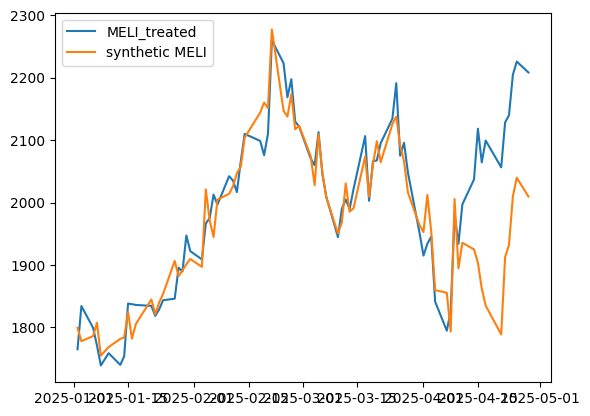

In [591]:
plt.figure()
plt.plot(df['Date'][df['ticker']=='MELI_treated'],df['price'][df['ticker']=='MELI_treated'],label=['MELI_treated'])
plt.plot(df['Date'][df['ticker']!='MELI_treated'],df['price'][df['ticker']!='MELI_treated'],label='synthetic MELI')

plt.legend()


In [ ]:
cutoff_date_1=pd.to_datetime(cutoff_date)
sml=df[df['ticker']!='MELI_treated']

sml=sml[sml['Date']>cutoff_date_1]




,price,Date,ticker
68,1935.590829,2025-04-11,MELI_synthetic
69,1924.927489,2025-04-14,MELI_synthetic
70,1903.691957,2025-04-15,MELI_synthetic
71,1862.370778,2025-04-16,MELI_synthetic
72,1834.956628,2025-04-17,MELI_synthetic
73,1788.785410,2025-04-21,MELI_synthetic
74,1912.688970,2025-04-22,MELI_synthetic
75,1931.925121,2025-04-23,MELI_synthetic
76,2009.858268,2025-04-24,MELI_synthetic
77,2039.750278,2025-04-25,MELI_synthetic


In [592]:

event_date = pd.to_datetime(cutoff_date)
treated_name = 'MELI_treated'

df['treated'] = np.where(df['ticker'] == treated_name, 1, 0)
df['post'] = np.where(df['Date'] >= event_date, 1, 0)
df['treated_post'] = df['treated'] * df['post']

df.head(n=200)

model = smf.ols('price ~ treated + post + treated_post', data=df).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:                  price   R-squared:                       0.085
Model:                            OLS   Adj. R-squared:                  0.067
Method:                 Least Squares   F-statistic:                     4.771
Date:                Wed, 30 Apr 2025   Prob (F-statistic):            0.00330
Time:                        21:05:54   Log-Likelihood:                -984.10
No. Observations:                 158   AIC:                             1976.
Df Residuals:                     154   BIC:                             1988.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept     1975.7233     15.181    130.145   

In [656]:
def robutsness(threated_stock,data):
    data_train=data[data['Date']<='2025-04-10']
    X_pred=data.drop(columns=[threated_stock,'Date'])

    X_train=data_train.drop(columns=[threated_stock,'Date'])
    y_train=data_train[threated_stock]

    X_train = sm.add_constant(X_train)
    X_pred= sm.add_constant(X_pred)
    model = Lasso(alpha=0.3)
    model.fit(X_train, y_train)
    df = model.predict(X_pred)

    # model = sm.OLS(y, X).fit()
    # df=model.predict(X_pred)

    return df #predicciones post treatment so they can be plotted

pred=pd.DataFrame()
stocks=['DASH','NU','EBAY','SHOP','SE','PINS','ETSY','PAGS','AMZN','STNE','PDD']

for i in stocks:
    pred[f'{i}']=robutsness(i,data_scaled)


pred=pred.join(data_scaled['Date'])
# pred=pred.drop(columns=['MELI'])

from sklearn.preprocessing import StandardScaler

pred=pd.merge(pred,pd.DataFrame(data_scaled[['MELI','Date']]),how='outer',on='Date')

synth=pred[pred['Date']>cutoff_date]

real=data_scaled[data_scaled['Date']>cutoff_date][['DASH','NU','EBAY','SHOP','SE','PINS','ETSY','PAGS','AMZN','STNE','PDD']]
real['MELI']=sml['price']

synth.head(n=10)
ATEs=(real-synth).mean()

synth

# PRE=(sum((ATE)**2)/10)**0.5
# PRE

,DASH,NU,EBAY,SHOP,SE,PINS,ETSY,PAGS,AMZN,STNE,PDD,Date,MELI
68,178.238635,9.830231,61.777754,86.062564,115.371188,28.051263,45.062216,7.765066,179.379823,10.350739,112.001118,2025-04-11,1996.949951
69,179.064044,9.765828,62.274051,85.804086,118.321595,28.224356,44.500850,7.915251,178.414517,10.616829,114.830694,2025-04-14,2037.119995
70,184.250307,9.432274,62.503443,84.856609,116.802595,29.180678,44.184400,8.087303,179.818543,10.754905,117.320194,2025-04-15,2118.320068
71,182.228024,9.234590,62.002973,81.570791,115.385628,28.667501,44.227205,8.028587,180.173603,10.793948,116.081804,2025-04-16,2064.370117
72,184.422863,9.200500,62.700430,82.735538,116.835147,28.924322,43.881174,8.150384,180.822174,10.980045,117.827151,2025-04-17,2099.370117
73,180.281186,8.621740,62.701638,77.851911,112.732990,27.924904,43.578618,8.005058,180.406399,10.838594,114.099642,2025-04-21,2056.429932
74,186.069412,8.972623,63.603532,82.678583,115.663759,29.067779,44.417644,8.137698,179.407552,10.927588,118.264311,2025-04-22,2128.330078
75,189.914274,9.496996,63.876222,86.810757,116.805428,30.310379,45.553093,8.130478,184.970688,10.842726,119.580320,2025-04-23,2139.919922
76,195.762029,9.917283,64.407560,90.413762,119.176280,31.784518,46.236133,8.264827,186.070647,10.969225,124.073265,2025-04-24,2204.810059
77,198.918579,9.994023,64.948136,91.426268,119.580938,32.470399,46.799838,8.277298,186.811231,10.925957,127.028162,2025-04-25,2225.850098


In [606]:
from sklearn.preprocessing import StandardScaler

# Separate


date_col = pred[['Date']]  # keep as DataFrame
features = pred.drop(columns=['Date'])

# Scale features only
scaler = StandardScaler()
features_scaled = pd.DataFrame(
    scaler.fit_transform(features),
    columns=features.columns,
    index=features.index
)

# Recombine if needed
df_scaled = pd.concat([date_col, features_scaled], axis=1)
df_scaled.tail()

,Date,DASH,NU,EBAY,SHOP,SE,PINS,ETSY,PAGS,AMZN,STNE,PDD,MELI
74,2025-04-22,-0.062294,-1.951960,-1.029968,-1.580644,-0.814826,-1.089978,-1.336287,1.075397,-1.475513,1.376185,0.437508,1.005705
75,2025-04-23,0.296540,-1.518302,-0.895236,-1.265457,-0.676185,-0.712945,-1.052726,1.061294,-1.194385,1.276720,0.582240,1.092656
76,2025-04-24,0.842302,-1.170724,-0.632710,-0.990633,-0.388275,-0.265657,-0.882147,1.323724,-1.138799,1.424988,1.076363,1.579481
77,2025-04-25,1.136897,-1.107259,-0.365620,-0.913403,-0.339135,-0.057545,-0.741370,1.348085,-1.101375,1.374273,1.401335,1.737329
78,2025-04-28,1.379176,-1.116053,-0.292293,-0.957915,-0.557880,-0.027898,-0.751791,1.321830,-1.060433,1.382368,1.343143,1.606413


Ticker,DASH,NU,EBAY,SHOP,SE,PINS,ETSY,PAGS,AMZN,STNE,PDD
68,180.490005,10.55,64.580002,83.709999,117.809998,26.370001,43.599998,8.39,184.869995,11.53,90.500000
69,181.850006,10.65,66.070000,82.769997,118.730003,25.850000,43.650002,8.48,182.119995,11.76,94.779999
70,181.550003,10.84,65.500000,83.910004,119.750000,25.990000,43.500000,8.52,179.589996,11.95,94.070000
71,179.389999,10.80,65.470001,83.959999,118.730003,25.450001,42.520000,8.41,174.330002,11.83,92.349998
72,181.240005,11.00,66.260002,83.650002,120.970001,25.260000,44.150002,8.53,172.610001,12.26,93.690002
73,171.820007,10.71,65.629997,81.639999,116.529999,24.209999,44.540001,8.47,167.320007,12.06,94.360001
74,176.610001,11.19,67.050003,85.709999,118.519997,24.680000,45.930000,9.35,173.179993,13.12,98.339996
75,181.190002,11.49,66.629997,90.959999,120.449997,25.610001,45.790001,9.24,180.600006,13.03,100.430000
76,187.220001,11.75,67.199997,95.120003,124.230003,25.750000,45.549999,9.61,186.539993,13.43,103.269997
77,187.759995,12.01,67.830002,97.120003,127.760002,26.059999,45.860001,9.88,188.990005,13.75,104.010002


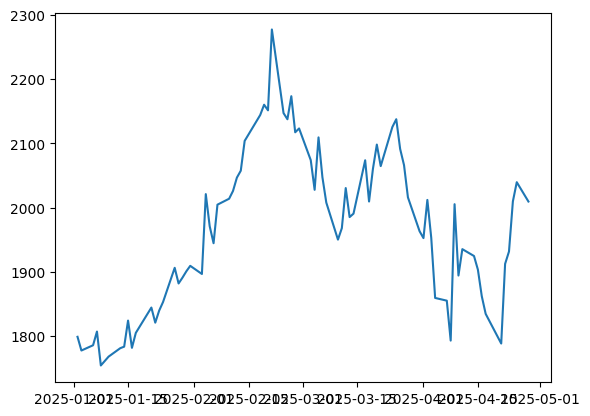

In [ ]:

plt.plot(df['Date'][df['ticker']!='MELI_treated'],df['price'][df['ticker']!='MELI_treated'],label='synthetic MELI')

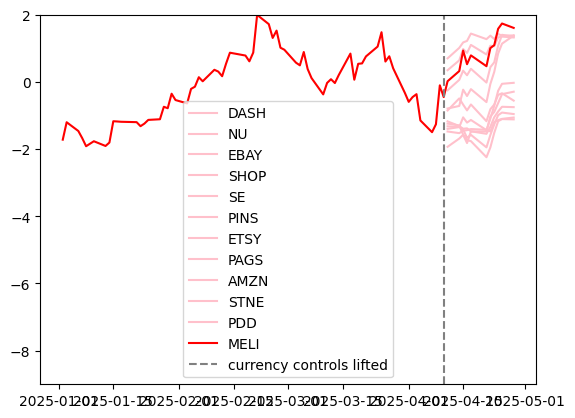

In [607]:

plt.figure()

for i in df_scaled.columns:
    if i=='Date':
        continue
    elif i!='MELI':
        plt.plot(df_scaled['Date'][df_scaled['Date']>cutoff_date],df_scaled[i][df_scaled['Date']>cutoff_date],c='pink',label=i)
    else:
        plt.plot(df_scaled['Date'],df_scaled[i],c='red',label=i)
        

plt.ylim(-9,2)
plt.axvline(x=pd.to_datetime(cutoff_date), color='gray', linestyle='--', label='currency controls lifted')
plt.legend()



In [422]:
import numpy as np
def get_stock_data(ticker, start_date,end_date):
    df=pd.DataFrame()
    df['Price']=yf.download(ticker,start=start_date,end=end_date, interval='1d')['Close']
    df.dropna(subset=['Price'], inplace=True)
    df.columns.name = None 
    df=df.reset_index()
    df['ticker'] = ticker
    df['Date'] = pd.to_datetime(df['Date'])
    return df

def get_data(tickers,start_date,end_date):
    df=pd.DataFrame()
    for i in tickers:
        df=pd.concat([df,get_stock_data(i,start_date,end_date)], axis=0)
    return df


df=get_data(['DASH','MELI'],'2024-10-14','2025-04-29')
df.head()

event_date = pd.to_datetime("2025-04-10")
treated_name = 'MELI'

df['treated'] = np.where(df['ticker'] == treated_name, 1, 0)
df['post'] = np.where(df['Date'] >= event_date, 1, 0)
df['treated_post'] = df['treated'] * df['post']

model = smf.ols('Price ~ treated + post + treated_post', data=df).fit()
print(model.summary())


[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.990
Model:                            OLS   Adj. R-squared:                  0.990
Method:                 Least Squares   F-statistic:                     8522.
Date:                Wed, 30 Apr 2025   Prob (F-statistic):          2.32e-262
Time:                        19:23:21   Log-Likelihood:                -1589.5
No. Observations:                 268   AIC:                             3187.
Df Residuals:                     264   BIC:                             3201.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept      178.1343      8.311     21.434   

__Beyond synthetic controls:__ 

Yes, lifting currency controls in Argentina will defintely help businesses like Mercado Libre over the long run. It is normal to expect an increase in its stock market. 
The cool thing about this exercise was to know, how much financial value was created for mercado libre. If we were to extrapolate this for all Argentinian economy, it definetly is good new for the country that 
everyone is curremtly watching 

However... we have not talked about the assumptions used in our example. We are asuming that the cepo cambiario did not affect other stocks. Nu comes from Brazil, Argetinas' largest trading partner. ' 
__SUTVA assumption.__

In principle, I do not forsee currency controls lift affecting NU's valuation. However, it is important to note that we could not estimate the effect if NU bank would have been affected too. For example, if we were to estimate the effect on brexit on the UK, we wold need to take into consideration tht Brexit also affected Germany and France's GDPs. Therefore, we could not use Frances or Germany's GDPs to estimate a wolrd in which brexit did not happen.